In [1]:
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None #to show all rows
pd.options.display.max_columns = None #to show all columns

# For encoding categorical data
from sklearn.preprocessing import OneHotEncoder

# For scaling
from sklearn.preprocessing import RobustScaler

# For splitting data
from sklearn.model_selection import train_test_split

# For modelling
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

# For evaluation
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

In [4]:
# verificando valores Nan
# apenas 1 linha de Nan
df.isna().sum()

In [5]:
df.dropna(inplace=True)

In [6]:
df.dtypes

In [7]:
# Aesthetics
sns.set_style('darkgrid')
sns.set_palette('Set2')
mpl_color = sns.color_palette('Set2')

# Plot features universal settings
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=13)
plt.rc('font', size=13)

In [10]:
df.shape

(284807, 30)

In [9]:
df1 = df.copy() # Just in case
df.drop('Time', axis = 1, inplace = True)
print(df.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  

In [14]:
dup = df[df.duplicated()]
print("Búmero de linhas duplicadas total:", len(dup))
print("Búmero de linhas duplicadas na coluna Fraud cases:", len(dup[dup["Class"]==1]))
print("Búmero de linhas duplicadas na coluna No Fraud cases:", len(dup[dup["Class"]==0]))

Búmero de linhas duplicadas total: 0
Búmero de linhas duplicadas na coluna Fraud cases: 0
Búmero de linhas duplicadas na coluna No Fraud cases: 0


In [15]:
total = len(df)
df.drop_duplicates(inplace=True)
print(total - len(df), "linhas duplicadas removidas")
print("Total de linhas que sobrou", len(df))

0 linhas duplicadas removidas
Total de linhas que sobrou 275663


Total de casos :275663  casos de fraude: 473
Total de casos :275663  casos de não fraude: 275190
Percentage of fraudes  : 0.172


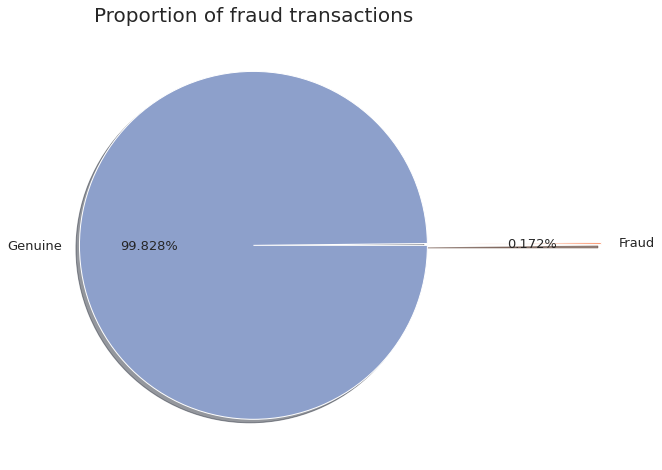

In [18]:
cases = len(df)
nonfraud_count = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])
fraud_percentage = round(fraud_count/cases*100, 3)
print("Total de casos :{}  casos de fraude:".format(cases), fraud_count)
print("Total de casos :{}  casos de não fraude:".format(cases), nonfraud_count)
print("Percentage of fraudes  :", fraud_percentage)

plt.figure(figsize = (8, 8))
pie_data = [df.Class[df["Class"] == 1].count(), df.Class[df["Class"] == 0].count()]
pie_labels = ["Fraud", "Genuine"]
plt.pie(pie_data, labels = pie_labels, explode = [1, 0], shadow = True, colors = mpl_color[1:3], autopct = "%.3f%%")
plt.title("Proportion of fraud transactions", size = 20)
plt.show()

Do total de 275.663 casos, apenas 0,172% dos casos são fraudes, o que causa um problema de desequilíbrio em nosso conjunto de dados.
A avaliação de nossos modelos finais será, portanto, feita não com base na precisão dos modelos, mas com base no número de transações de fraude corretamente previstas de todas as transações de fraude reais, ou seja, o recall de nosso algoritmo.

In [19]:
print(df[df['Class']==0].Amount.describe())
print(df[df['Class']==1].Amount.describe())

count    275190.000000
mean         90.521154
std         253.198478
min           0.000000
25%           6.390000
50%          23.750000
75%          79.900000
max       25691.160000
Name: Amount, dtype: float64
count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


O intervalo de dados da coluna Amount precisa der padronizado para o modelo prever as classes corretamente.
Será usado o RobustScaler para fazer isso, pois ele é robusto aos outliers, já que ele remove a mediana e dimensiona os dados no intervalo entre o primeiro e o terceiro quartil.

In [21]:
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

Mesmo que não saibamos quais são os recursos "V", ainda precisamos saber o quanto eles influenciam a variável de destino (Fraud ou No Fraud). Por ter um dataframe desequilibrado, não poderemos ver as verdadeiras correlações entre a classe e os recursos. Portanto, devemos subamostrar a Classe 0 para reduzi-la a proporções iguais com a Classe 1.

Antes de subamostrar, precisamos ter um conjunto de dados de teste dos dados originais, esses dados de teste devem ser completamente novos para o modelo durante as previsões. Portanto, faremos uma divisão de teste e de treino e prosseguiremos com a subamostragem.

In [25]:
X_orig = df.loc[:,df.columns != "Class"]
y_orig = df.Class
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size = 0.2)

Undersampling

In [26]:
df_train = pd.concat([X_train, y_train], axis=1)
print("Porcentagem dos casos de fraude:", round(len(df_train[df_train.Class == 1])/len(df_train)*100, 3))
print("Número de casos de fraude:", len(df_train[df_train.Class == 1]))

# Lets shuffle the data before creating the new balanced dataframe
df_train = df_train.sample(frac=1)

fraud_df_train = df_train.loc[df_train['Class'] == 1]
non_fraud_df_train = df_train.loc[df_train['Class'] == 0][:len(fraud_df_train)]

balanced_df_train = pd.concat([fraud_df_train, non_fraud_df_train])

# Shuffle again
balanced_df_train = balanced_df_train.sample(frac=1, random_state=42)
print("Porcentagem dos casos de fraude depois do rebalanceamento:", round(len(balanced_df_train[balanced_df_train.Class == 1])/len(balanced_df_train)*100, 3))
print("Número de casos de fraude depois do rebalanceamento:", len(balanced_df_train[balanced_df_train.Class == 1]))
balanced_df_train.info()

Porcentagem dos casos de fraude: 0.172
Número de casos de fraude: 380
Porcentagem dos casos de fraude depois do rebalanceamento: 50.0
Número de casos de fraude depois do rebalanceamento: 380
<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 176002 to 79525
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      760 non-null    float64
 1   V2      760 non-null    float64
 2   V3      760 non-null    float64
 3   V4      760 non-null    float64
 4   V5      760 non-null    float64
 5   V6      760 non-null    float64
 6   V7      760 non-null    float64
 7   V8      760 non-null    float64
 8   V9      760 non-null    float64
 9   V10     760 non-null    float64
 10  V11     760 non-null    float64
 11  V12     760 non-null    float64
 12  V13     760 non-null    float64
 13  V14     760 non-null    float64
 14  V15     760 non-null    float64
 15  V16     760 non-null    float64
 16  V17     760 non-null    fl

Verificando a correlação após a subamostragem
Vamos verificar a matriz de correlação e obter mais insights que possam afetar a variável target.

In [38]:
balanced_df_train.corr()["Class"][:-1].to_frame().sort_values('Class', ascending=False)

,Class
V4,0.691873
V11,0.680115
V2,0.474969
V19,0.262790
V20,0.188410
V8,0.111115
V21,0.105007
V27,0.103227
V28,0.080464
Amount,0.071274


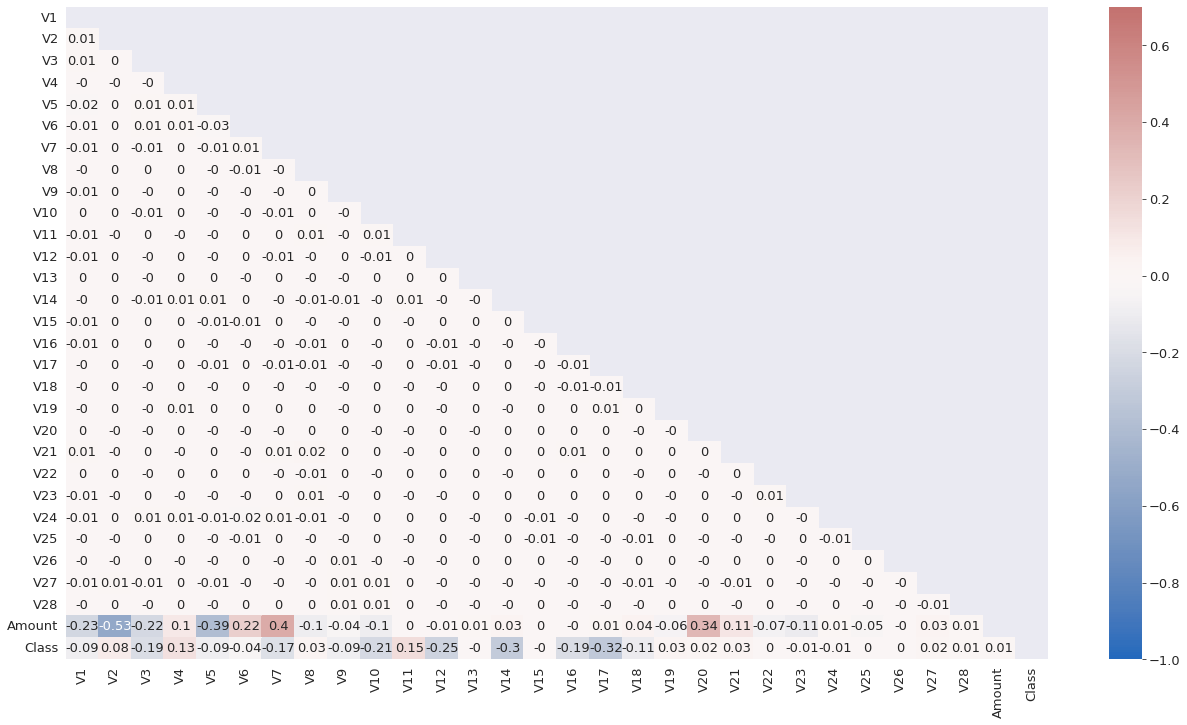

In [30]:
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(22,12)) 
sns.heatmap(matrix, annot=True, vmax=0.7, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

Maiores correlações negativas - V14 V12 V10
Maiores correlações positivas - V11 V4

Vamos ver como se comportam as de maior correlação negativa

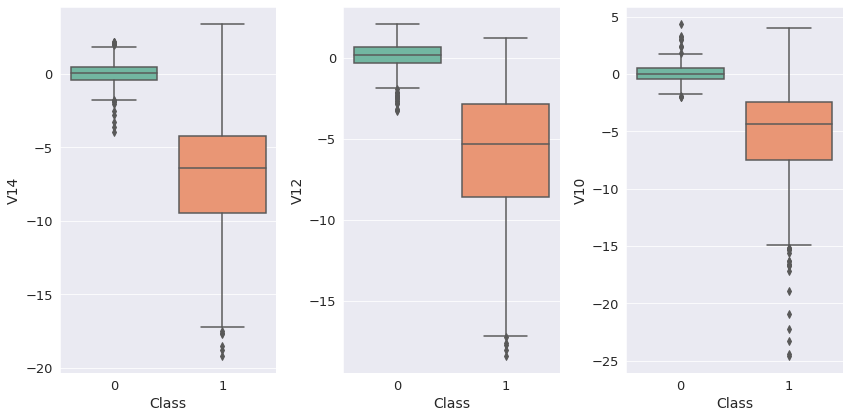

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(12,6), tight_layout = True)
sns.boxplot(x="Class",y="V14", data=balanced_df_train, ax=ax[0])
sns.boxplot(x="Class",y="V12", data=balanced_df_train, ax=ax[1])
sns.boxplot(x="Class",y="V10", data=balanced_df_train, ax=ax[2])

plt.show()

Vamos ver como se comportam as de maior correlação positiva

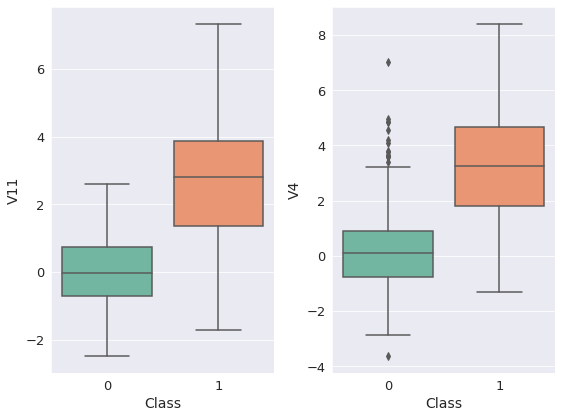

In [45]:
fig, ax = plt.subplots(ncols=2, figsize=(8,6), tight_layout = True)
sns.boxplot(x="Class",y="V11", data=balanced_df_train, ax=ax[0])
sns.boxplot(x="Class",y="V4", data=balanced_df_train, ax=ax[1])

plt.show()

Precisamos agora cuidar dos outliers, pois prever um caso de não fraude como sendo fraude também é importante para não desmotivar os clientes idôneos 

In [43]:
out_features = ["V14", "V12", "V10","V11","V4"]
for feature in out_features:
    Q1 = balanced_df_train[feature].quantile(0.25)
    Q3 = balanced_df_train[feature].quantile(0.75)
    IQR = Q3-Q1
    top = Q3 + 1.5*IQR # Not necessary for negatively correlated features
    bottom = Q1 - 1.5*IQR

    index = balanced_df_train[(balanced_df_train[feature] < bottom)].index
    print(len(index), " outliers da coluna ", feature, " foram removidos do dataset")
    balanced_df_train = balanced_df_train.drop(index)

4  outliers da coluna  V14  foram removidos do dataset
8  outliers da coluna  V12  foram removidos do dataset
15  outliers da coluna  V10  foram removidos do dataset
0  outliers da coluna  V11  foram removidos do dataset
0  outliers da coluna  V4  foram removidos do dataset


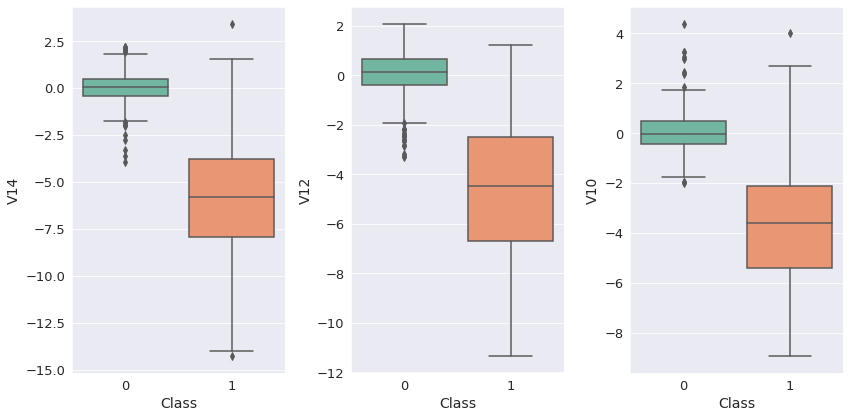

In [42]:
fig, ax = plt.subplots(ncols=3, figsize=(12,6), tight_layout = True)
sns.boxplot(x="Class",y="V14", data=balanced_df_train, ax=ax[0])
sns.boxplot(x="Class",y="V12", data=balanced_df_train, ax=ax[1])
sns.boxplot(x="Class",y="V10", data=balanced_df_train, ax=ax[2])

plt.show()

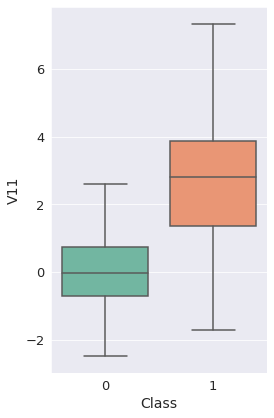

In [44]:
plt.figure(figsize=(4,6), tight_layout = True)
sns.boxplot(x="Class",y="V11", data=balanced_df_train)
plt.show()

Todos os outliers foram tratados. Vamos prosseguir com a modelagem.

Modelagem após subamostragem
Os seguintes modelos serão testados neste estudo de caso:

- Classificador de regressão logística
- Classificador KNN
- Classificador SV
- Classificador de Floresta Aleatória
- Classificador XGB

Para cada algoritmo, faremos o ajuste de hiperparâmetros usando GridSearchCV para obter os melhores parâmetros e a melhor pontuação de CV. Em seguida, aplicaremos cada melhor modelo novamente para obter a pontuação do treinamento.
Alta pontuação de treinamento e baixa pontuação CV ==> Overfitting ao conjunto de treinamento Baixa pontuação de treinamento e baixa pontuação CV ==> Underfitting Ambas as pontuações altas ==> Um bom modelo generalizado

In [46]:
y_balanced = balanced_df_train.Class
X_balanced = balanced_df_train.loc[:, balanced_df_train.columns != 'Class']

Regressão Logistica

In [47]:
param_grid = {'C': [0.1,0.5,1,10], 'max_iter' : [500, 750], 'tol':[0.00001,0.0001, 0.001]}
lr_grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5)
lr_grid.fit(X_balanced, y_balanced)
print(lr_grid.best_score_)    
print(lr_grid.best_params_)
print(lr_grid.best_estimator_)

0.9325664908540006
{'C': 1, 'max_iter': 500, 'tol': 1e-05}
LogisticRegression(C=1, max_iter=500, solver='liblinear', tol=1e-05)


Regressão logística - Ajustando modelo

In [48]:
lr_model = LogisticRegression(C=0.5, max_iter=500, solver='liblinear', tol=1e-05)
lr_model.fit(X_balanced, y_balanced)
lr_yhat = lr_model.predict(X_balanced)
print(classification_report(y_balanced, lr_yhat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       380
           1       0.97      0.91      0.94       287

    accuracy                           0.95       667
   macro avg       0.95      0.94      0.95       667
weighted avg       0.95      0.95      0.95       667



KNN Classifier

In [49]:
param_grid = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn_grid.fit(X_balanced, y_balanced)

print(knn_grid.best_score_)    
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.9280776568286389
{'algorithm': 'auto', 'n_neighbors': 2}
KNeighborsClassifier(n_neighbors=2)


KNN - Fit best model

In [50]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_balanced, y_balanced)
knn_yhat = knn_model.predict(X_balanced)
print(classification_report(y_balanced, knn_yhat))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       380
           1       0.98      0.91      0.95       287

    accuracy                           0.96       667
   macro avg       0.96      0.95      0.95       667
weighted avg       0.96      0.96      0.95       667



SVM Classifier

In [51]:
param_grid = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
svc_grid = GridSearchCV(SVC(), param_grid, cv=5)
svc_grid.fit(X_balanced, y_balanced)

print(svc_grid.best_score_)    
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

0.9310851756256312
{'C': 0.7, 'kernel': 'linear'}
SVC(C=0.7, kernel='linear')


SVC - Fit best model

In [52]:
svc_model = SVC(C=0.5, kernel='linear')
svc_model.fit(X_balanced, y_balanced)
svc_yhat = svc_model.predict(X_balanced)
print(classification_report(y_balanced, svc_yhat))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       380
           1       0.96      0.90      0.93       287

    accuracy                           0.94       667
   macro avg       0.95      0.94      0.94       667
weighted avg       0.94      0.94      0.94       667



Random Forest Classifier

In [53]:
param_grid = {'max_depth': [5, 6, 7, 8], 'max_features': [4,5,6,7,8],'n_estimators':[100, 250, 500],'min_samples_split': [4, 5, 6, 7]}
rf_grid = GridSearchCV(RandomForestClassifier(),param_grid, cv=5)
rf_grid.fit(X_balanced, y_balanced)
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.9385478621927955
{'max_depth': 8, 'max_features': 7, 'min_samples_split': 4, 'n_estimators': 100}
RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=4)


RF - Fit best model

In [54]:
rf_model = RandomForestClassifier(max_depth=6, max_features=5, min_samples_split=7, n_estimators=100)
rf_model.fit(X_balanced, y_balanced)
rf_yhat = rf_model.predict(X_balanced)
print(classification_report(y_balanced, rf_yhat))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       380
           1       1.00      0.91      0.95       287

    accuracy                           0.96       667
   macro avg       0.97      0.95      0.96       667
weighted avg       0.96      0.96      0.96       667



XGB Classifier

In [55]:
param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001], 'n_estimators':[500, 750], 'min_child_weight':[1,5,10]}
xgb_grid = GridSearchCV(XGBClassifier(),param_grid, cv=5)
xgb_grid.fit(X_balanced, y_balanced)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

0.9355627875659298
{'gamma': 0.001, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500}
XGBClassifier(gamma=0.001, max_depth=8, n_estimators=500)


XGB - Fit best model

In [56]:
xgb_model = XGBClassifier(max_depth=5, gamma=0.001, min_child_weight=1, n_estimators=500)
xgb_model.fit(X_balanced, y_balanced)
xgb_yhat = xgb_model.predict(X_balanced)
print(classification_report(y_balanced, xgb_yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00       287

    accuracy                           1.00       667
   macro avg       1.00      1.00      1.00       667
weighted avg       1.00      1.00      1.00       667



Selecionando o melhor
De todos os modelos e suas pontuações, o Random Forest Classifier deu os melhores resultados em termos de pontuação de treinamento e CV, tendo em mente a generalização do modelo para evitar overfitting e ainda ser capaz de prever com precisão em dados não vistos.
Ajustando o melhor modelo em dados de teste:

In [57]:
rf_test_yhat = rf_model.predict(X_test)
print(classification_report(y_test, rf_test_yhat))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     55040
           1       0.06      0.84      0.12        93

    accuracy                           0.98     55133
   macro avg       0.53      0.91      0.55     55133
weighted avg       1.00      0.98      0.99     55133



Como podemos ver nas pontuações dos testes acima, o método de subamostragem neste cenário não teve um bom desempenho para o modelo treinar adequadamente nos casos de fraude. O modelo ainda está prevendo 0 ou Não fraude para muitos dos casos de Fraude.
De todos os casos reais de fraude (110), o modelo conseguiu prever 85% deles corretamente (como fraude).
De todas as fraudes previstas, apenas 10% foram realmente fraudes. Isso significa que esse modelo deixou muitos clientes indignados, acusando-os de fraude, por engano, é claro.


Sobreamostragem (SMOTE)
Tentaremos aumentar a amostragem da minoria usando a Técnica de Sobreamostragem da Minoria Sintética. Depois disso, aplicaremos as mesmas etapas da subamostragem para obter o conjunto de dados final para modelagem e previsões.

In [58]:
from imblearn.over_sampling import SMOTE

In [59]:
smote = SMOTE(sampling_strategy="minority")
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [60]:
y_sm.value_counts()

0    220150
1    220150
Name: Class, dtype: int64

A minoria foi superestimada para corresponder à maioria anterior.

Verificando a correlação após o SMOTE

In [61]:
df_sm_train = pd.concat([X_sm, y_sm], axis=1)
# df_sm_train.corr()["Class"][:-1]

In [62]:
df_sm_train.corr()["Class"][:-1].to_frame().sort_values('Class', ascending=False)

,Class
V4,0.704967
V11,0.694578
V2,0.488230
V19,0.291483
V20,0.205340
V8,0.153100
V21,0.139725
V27,0.128886
V28,0.114013
V25,0.054415


In [63]:
out_features = ["V14", "V12", "V10"]
for feature in out_features:
    Q1 = df_sm_train[feature].quantile(0.25)
    Q3 = df_sm_train[feature].quantile(0.75)
    IQR = Q3-Q1
    top = Q3 + 1.5*IQR # Not necessary for negatively correlated features
    bottom = Q1 - 1.5*IQR

    index = df_sm_train[(df_sm_train[feature] < bottom)].index
    print(len(index), " number of", feature, " outliers removed from the dataset")
    df_sm_train = df_sm_train.drop(index)

4262  number of V14  outliers removed from the dataset
23919  number of V12  outliers removed from the dataset
9762  number of V10  outliers removed from the dataset


Modelagem após SMOTE

In [64]:
y_sm_new = df_sm_train.Class
X_sm_new = df_sm_train.loc[:, df_sm_train.columns != 'Class']

In [65]:
rf_sm_model = RandomForestClassifier(max_depth=6, max_features=5, min_samples_split=7, n_estimators=100)
rf_sm_model.fit(X_sm_new, y_sm_new)
rf_sm_yhat = rf_sm_model.predict(X_sm_new)
print(classification_report(y_sm_new, rf_sm_yhat))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    220133
           1       0.99      0.90      0.95    182224

    accuracy                           0.95    402357
   macro avg       0.96      0.95      0.95    402357
weighted avg       0.96      0.95      0.95    402357



Agora vamos prever usando este modelo

In [66]:
rf_sm_test_yhat = rf_sm_model.predict(X_test)
print(classification_report(y_test, rf_sm_test_yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55040
           1       0.22      0.83      0.35        93

    accuracy                           0.99     55133
   macro avg       0.61      0.91      0.67     55133
weighted avg       1.00      0.99      1.00     55133



Conclusão: 